# Training Recurrent Neural Nets

This week we'll train recurrent neural networks. Here it's all about processing an stream of data in a particular order, which happens for example for time-series data.

RNNs process the data by introducing "memory" which they modify based on each time-steps data.

To see how this works, we'll work on classifying sequences into binary categories:

* sequences with just positive random integers vs.
* sequence with a -1 somewhere in the sequence

The RNN will need to track the elements in the sequence and store into memory whether it has seen a "-1" or not



## Step 1 Write a sequence generator

To start let's write a data generating function 

* Write a function `make_datum(size)` that creates a array of size `size` filled with random integers between 0 and 9

* With a probability of 50% overwrite a random position with a -1

* The function should return `x` as an `(size,1)` array and `y` as a label (0 for unmodified, 1 for modified)

## Step 2 Write a mini-batch generator

To generate minibatches of data create a function `make_data(N)` that randomly samples a data size between 10 and 25 and produces `N` samples of data with that chosen size. The output should look as follows:

* The data array should be of shape `(Nbatch, size, 1)`
* The label array should be of shape `(Nbatch, 1)`

In [62]:
import numpy as np
import torch

def make_datum(size):
    x = np.random.randint(0,10, size = (size,))
    y = np.random.binomial(1,0.5)
        
    if y:
        pos = np.random.randint(0,size)
        x[pos] = -1
    return x.reshape(-1,1),y

def make_data(N = 500):
    size = np.random.randint(10,25)
    xy = [make_datum(size) for i in range(N)]
    X = np.array([x for x,y in xy])
    y = np.array([y for x,y in xy])
    return torch.FloatTensor(X),torch.FloatTensor(y.reshape(-1,1))

## Step 3: Create a RNN class

Create a `torch.nn.Module` subclass that holds two sub-modules

* a RNN that consumes the sequence of N elements and produces a sequence of N outputs. Make the class configurable, such that one could use either `torch.nn.RNN` or `torch.nn.LSTM` as a possibile RNN flavor


* a MLP that implements the "high-level" task of doing binary classification based on an output vector. Here a simple perceptron-style network that is just a linear layer followed by a sigmoid is sufficient

In the `forward` of your module, pass the input sequence through the RNN. This returns to you the output sequence (and additionally some data about the hidden memory states)

Pass the output sequence (all time steps) through your MLP "head" network. This will give you information how the decision evolves as the sequence is processed. The final answer is the output of the MLP at the last time-step

The `forward` should return both the final answer as well as the full sequence of decisions leading up to it

In [63]:
class MyRNN(torch.nn.Module):
    def __init__(self, rnn_cls = torch.nn.RNN):
        super().__init__()
        self.NH = 10
        self.rnn = rnn_cls(1,self.NH, batch_first = True, num_layers = 1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.NH,1),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        Y,H = self.rnn(x)
        out = self.mlp(Y)
        answer = out[:,-1,:]
        return answer,out

## Step 4: Write a training loop and train the networks

Write a training loop for our RNN with signature `train(rnn_cls)`, where `rnn_cls` is either `torch.nn.LSTM` or `torch.nn.RNN` that trains your new module on the data we get from the data-generating process you wrote above. Add code that tracks the evolution of the loss during training

* Use your training loop to train both a `LSTM`- and a `RNN`-based network
* Plot the loss curves for both

In [65]:
def train(rnn_cls):
    trajectory = []
    model = MyRNN(rnn_cls)
    opt = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(3000):
        X,y = make_data(100)
        p,HX = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        trajectory.append([i,float(loss),X.shape[1]])
        if i % 250 == 0:
            print(float(loss))
    return model,np.array(trajectory)

trained_lstm,traj_lstm = train(torch.nn.LSTM)
trained_rnn,traj_rnn = train(torch.nn.RNN)

0.7218310832977295
0.6201066374778748
0.21410198509693146
0.0829242691397667
0.05589338392019272
0.028661862015724182
0.014928493648767471
0.01264127530157566
0.008821307681500912
0.008995695039629936
0.008787407539784908
0.0052207475528120995
0.7026408314704895
0.6802220940589905
0.5557267069816589
0.5145632028579712
0.34898650646209717
0.18819288909435272
0.13146720826625824
0.09987317025661469
0.07725480198860168
0.02899342216551304
0.055648937821388245
0.04556263983249664


(0.0001, 1)

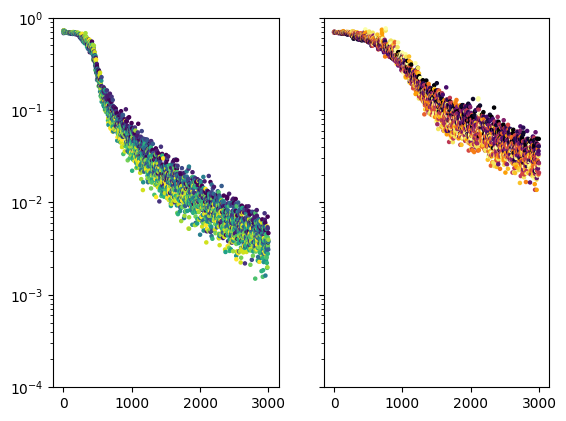

In [66]:
import matplotlib.pyplot as plt
f,axarr = plt.subplots(1,2, sharey = True)
ax = axarr[0]
ax.scatter(traj_lstm[:,0],traj_lstm[:,1], c = traj_lstm[:,2], cmap = 'viridis', s = 5)
ax.set_yscale('log')
ax.set_ylim(1e-4,1)

ax = axarr[1]
ax.scatter(traj_rnn[:,0],traj_rnn[:,1], c = traj_rnn[:,2], cmap = 'inferno', s = 5)
ax.set_yscale('log')
ax.set_ylim(1e-4,1)

## Step 5: Testing the results

To see how the decision is being reached as the sequence in being processed, try out the following thing

* take the array [1,2,3,4,5,6,7,8,9]
* Write code that visualizes the output for all time steps of the trained models
* Visualize the output
* go back to your test array and place a -1 at a position of your choosing, re-visualize and see whether the RNN changes it's decision at the right moment

In [76]:
x = [[1,2,3,4,-1,6,7,8,9]]

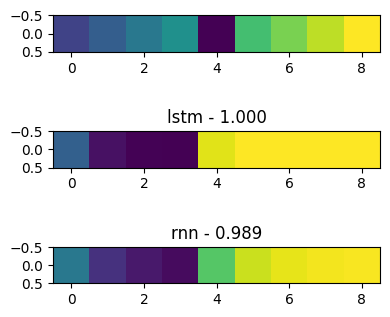

In [77]:
def plot(X,lstm_model, rnn_model):
    X = torch.FloatTensor(X).reshape(1,-1,1)
    f,axarr = plt.subplots(3,1)
    ax = axarr[0]
    ax.imshow(X[:1].reshape(1,-1))

    ax = axarr[1]
    with torch.no_grad():
        a,output = lstm_model(X[:1])
    ax.imshow(output.numpy()[0].T, vmin = 0, vmax = 1)
    ax.set_title(f'lstm - {a[0,0]:.3f}')
    ax = axarr[2]
    with torch.no_grad():
        a,output = rnn_model(X[:1])
    ax.imshow(output.detach().numpy()[0].T, vmin = 0, vmax = 1)
    ax.set_title(f'rnn - {a[0,0]:.3f}')

    f.set_size_inches(4,4)
    f.set_tight_layout(True)
    
plot(x,trained_lstm,trained_rnn)